# Assignment III

Atahan Özer - 6317973\
Karahan Sarıtaş - 6661689

## Problem 3
**(a)** Implement the Dirac, uniform, multitask and peptide kernel functions.

Approach:
* Ahead of cross-validation, we pre-calculate the gram matrix for each kernel function to save time and prevent redundant computations.
* We split the data into two sets: training and test set. Training set is splitted into 10 in each run and 1 of these 10 is used as validation set. We use the validation set to find the best hyperparameters for each kernel function.
* Throughout cross-validation, we log accuracy outcomes on the validation set for each kernel function. Subsequently, we analyze these outcomes to identify the optimal hyperparameters.
* Simultaneously, we record the results of each configuration on the test set. While these results aren't utilized for hyperparameter selection, they serve the purpose of comparing the kernel functions' performance on ROC curves.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# read BindingData.csv
binding_data = pd.read_csv('BindingData.csv')
binding_data.head()

,Epitope ID,binding information,allele,peptide sequence,binding label
0,52886,Positive,HLA-A*01:01,QYDPVAALF,1
1,71650,Positive,HLA-A*01:01,VVEKQSGLY,1
2,150319,Positive,HLA-A*01:01,ITEAELTGY,1
3,141221,Positive,HLA-A*01:01,ATDSLNNEY,1
4,24819,Positive,HLA-A*01:01,HSNLNDATY,1


In [3]:
binding_data.columns

Index(['Epitope ID', ' binding information', ' allele', ' peptide sequence',
       ' binding label'],
      dtype='object')

In [4]:
# X: [peptide sequence, allele]
# y: binding label

peptides = list(binding_data[' peptide sequence'])
alleles = list(binding_data[' allele'])
for i in range(len(alleles)):
    alleles[i] = alleles[i].replace(':', "").replace('HLA-', "")
X = np.array([[p, a] for p, a in zip(peptides, alleles)])
y = np.array(binding_data[' binding label'])

X.shape, y.shape

((1297, 2), (1297,))

In [7]:
def dirac(a, b): return a == b                                    # allele kernel
def uniform(*_): return 1                                         # allele kernel
def multitask(a, b): return dirac(a, b) + uniform(a, b)           # allele kernel

def linseq(a, b): return sum(1 for x, y in zip(a, b) if x == y)   # peptide kernel

def joint_wrapper(pep_kernel, all_kernel): 
    def joint(A, B):
        K_pep = np.array([[pep_kernel(a, b) for a in A[:, 0]] for b in B[:, 0]])  # A[0] B[0] --> peptide
        K_all = np.array([[all_kernel(a, b) for a in A[:, 1]] for b in B[:, 1]])  # A[1] B[1] --> allele
        return K_pep * K_all
    return joint
        
allele_kernels = [dirac, uniform, multitask]
peptide_kernels = [linseq]

**(b)** Build SVM models using the Dirac kernel, the uniform kernel, and a multitask kernel (consisting of the two former kernels) in combination with the peptide kernel in the cross-validations with $C \in \{10^{−4}, 10^{−3}, ..., 10^{2}\}$.


In [8]:
C = [10**i for i in range(-4, 3)]
C   

[0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

In [9]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1037, 2), (260, 2), (1037,), (260,))

In [11]:
# compute gram matrix beforehand to feed SVC with precomputed kernel
gram_matrix_dirac = joint_wrapper(linseq, dirac)(X_train, X_train)
gram_matrix_uniform = joint_wrapper(linseq, uniform)(X_train, X_train)
gram_matrix_multitask = joint_wrapper(linseq, multitask)(X_train, X_train)

gram_matrix_dirac_test = joint_wrapper(linseq, dirac)(X_train, X_test)
gram_matrix_uniform_test = joint_wrapper(linseq, uniform)(X_train, X_test)
gram_matrix_multitask_test = joint_wrapper(linseq, multitask)(X_train, X_test)

gram_matrix = {'dirac': gram_matrix_dirac,
               'uniform': gram_matrix_uniform,
               'multitask': gram_matrix_multitask}

gram_matrix_test = {'dirac': gram_matrix_dirac_test,
                    'uniform': gram_matrix_uniform_test,
                    'multitask': gram_matrix_multitask_test}

In [44]:
"""
We shouldn't touch test data until you finish. 
To do cross validation we have to split the training dataset into train and validation sets.
"""

# OPTIMIZED ~ 1.30 min - Calculate the kernel matrix only once

kf = KFold(n_splits=10, shuffle=True, random_state=15)
def CV(gram_matrix, y_train, allele_kernels=allele_kernels, peptide_kernels=peptide_kernels, C=C):
    test_output = {}
    cv_output = {}
    for c in C:
        for allele_kernel in allele_kernels:
            for peptide_kernel in peptide_kernels:
                scores = []
                print("<", "-" * 60, ">", sep="")
                print('C = {}, allele_kernel = {}, peptide_kernel = {}'.format(c, allele_kernel.__name__, peptide_kernel.__name__))
                for train_index, val_index in kf.split(gram_matrix[allele_kernel.__name__]):
                    clf = SVC(kernel='precomputed', C=c)
                    clf.fit(gram_matrix[allele_kernel.__name__][train_index][:, train_index], y_train[train_index])
                    y_pred =  clf.predict(gram_matrix[allele_kernel.__name__][val_index][:, train_index])
                    y_truth = y_train[val_index]
                    score = accuracy_score(y_truth, y_pred)
                    scores.append(score)
                    print('Run {}: score = {:.4f}'.format(len(scores), score))

                # get results on test set to visualize in ROC curve
                clf = SVC(probability=True, kernel='precomputed', C=c)
                clf.fit(gram_matrix[allele_kernel.__name__], y_train)
                y_pred_proba = clf.predict_proba(gram_matrix_test[allele_kernel.__name__])
                # just take p[1] for all p in y_pred_proba
                y_pred_proba = np.array([p[1] for p in y_pred_proba])
                y_pred = np.array([1 if p > 0.5 else 0 for p in y_pred_proba])
                y_truth = y_test
                test_output[(c, allele_kernel.__name__, peptide_kernel.__name__)] = (y_pred_proba, y_truth)
                cv_output[(c, allele_kernel.__name__, peptide_kernel.__name__)] = np.mean(scores)

                print('Mean score = {:.4f}'.format(np.mean(scores)))
    return test_output, cv_output

test_output, cv_output = CV(gram_matrix, y_train)

<------------------------------------------------------------>
C = 0.0001, allele_kernel = dirac, peptide_kernel = linseq
Run 1: score = 0.5673
Run 2: score = 0.6538
Run 3: score = 0.4808
Run 4: score = 0.4327
Run 5: score = 0.5000
Run 6: score = 0.4904
Run 7: score = 0.5192
Run 8: score = 0.5243
Run 9: score = 0.5631
Run 10: score = 0.5922
Mean score = 0.5324
<------------------------------------------------------------>
C = 0.0001, allele_kernel = uniform, peptide_kernel = linseq
Run 1: score = 0.5673
Run 2: score = 0.6538
Run 3: score = 0.4808
Run 4: score = 0.4327
Run 5: score = 0.5000
Run 6: score = 0.4904
Run 7: score = 0.5192
Run 8: score = 0.5243
Run 9: score = 0.5631
Run 10: score = 0.5922
Mean score = 0.5324
<------------------------------------------------------------>
C = 0.0001, allele_kernel = multitask, peptide_kernel = linseq
Run 1: score = 0.5673
Run 2: score = 0.6538
Run 3: score = 0.4808
Run 4: score = 0.4327
Run 5: score = 0.5000
Run 6: score = 0.4904
Run 7: score =

In [11]:
# Max accuracy and corresponding parameters
max(cv_output, key=cv_output.get), cv_output[max(cv_output, key=cv_output.get)]

((0.1, 'multitask', 'linseq'), 0.6316280806572069)

In [12]:
# test best result on test set
clf = SVC(kernel='precomputed', C=0.1)
clf.fit(gram_matrix["uniform"], y_train) # train
y_pred = clf.predict(joint_wrapper(linseq, uniform)(X_train, X_test)) # test
accuracy_score(y_test, y_pred)

0.6153846153846154

**(c)** What happens if you add another Dirac kernel that is based on the supertypes (```supertype.csv```) from
LANL (where available) to the multitask kernel?


In [13]:
# read supertype.csv
supertype = pd.read_csv('supertype.csv')
supertype.head()

,Supertype,Motif,Genotypes
0,A1,x[TI(SVLM)]xxxxxx[WFY],"A*0101, A*0102, A*2501, A*2601, A*2604, A*3201..."
1,A2,x[LIVMATQ]xxxxxx[LIVMAT],"A*0201, A*0202, A*0203, A*0204, A*0205, A*0206..."
2,A3,x[AILMVST]xxxxxx[RK],"A*0301, A*1101, A*3101, A*3301, A*6801"
3,A24,x[YF(WIVLMT)]xxxxxx[FI(YWLM)],"A*2301, A*2402, A*2403, A*2404, A*3001, A*3002..."
4,B7,x[P]xxxxxx[ALIMVFWY],"B*0702, B*0703, B*0704, B*0705, B*1508, B*3501..."


In [14]:
# get supertypes and corresponding alleles, and build a dictionary
supertypes = list(supertype['Supertype'])
genotypes = list(supertype['Genotypes'])

# create genotype-supertype dictionary
genotype_supertype = {}
for supertype_, genotypes_ in zip(supertypes, genotypes):
    for genotype_ in genotypes_.split(','):
        genotype_supertype[genotype_.strip()] = supertype_.strip()
genotype_supertype


{'A*0101': 'A1',
 'A*0102': 'A1',
 'A*2501': 'A1',
 'A*2601': 'A1',
 'A*2604': 'A1',
 'A*3201': 'A1',
 'A*3601': 'A1',
 'A*4301': 'A1',
 'A*8001': 'A1',
 'A*0201': 'A2',
 'A*0202': 'A2',
 'A*0203': 'A2',
 'A*0204': 'A2',
 'A*0205': 'A2',
 'A*0206': 'A2',
 'A*0207': 'A2',
 'A*6802': 'A2',
 'A*6901': 'A2',
 'A*0301': 'A3',
 'A*1101': 'A3',
 'A*3101': 'A3',
 'A*3301': 'A3',
 'A*6801': 'A3',
 'A*2301': 'A24',
 'A*2402': 'A24',
 'A*2403': 'A24',
 'A*2404': 'A24',
 'A*3001': 'A24',
 'A*3002': 'A24',
 'A*3003': 'A24',
 'B*0702': 'B7',
 'B*0703': 'B7',
 'B*0704': 'B7',
 'B*0705': 'B7',
 'B*1508': 'B7',
 'B*3501': 'B7',
 'B*3502': 'B7',
 'B*3503': 'B7',
 'B*51': 'B7',
 'B*5301': 'B7',
 'B*5401': 'B7',
 'B*5501': 'B7',
 'B*5502': 'B7',
 'B*5601': 'B7',
 'B*5602': 'B7',
 'B*6701': 'B7',
 'B*7801': 'B7',
 'B*1401': 'B27',
 'B*1402': 'B27',
 'B*1503': 'B27',
 'B*1509': 'B27',
 'B*1510': 'B27',
 'B*1518': 'B27',
 'B*2701': 'B27',
 'B*2702': 'B27',
 'B*2703': 'B27',
 'B*2704': 'B27',
 'B*2705': 'B27'

In [50]:
for all in set(alleles):
    if all not in genotype_supertype.keys():
        print('Allele {} not found in supertype.csv'.format(all))

In [51]:
# Allele A*2902 not found in supertype.csv
# According to the following paper, A*2902 belongs to supertype A1:
# Sidney J, Southwood S, Sette A. Classification of A1- and A24-supertype molecules by analysis of their MHC-peptide binding repertoires. 
# Immunogenetics. 2005 Jul;57(6):393-408. doi: 10.1007/s00251-005-0004-2. Epub 2005 Jul 8. PMID: 16003466.
#
# quote: "...Based on the present findings, the A1 supertype includes A*0101, A*2601, A*2902, and A*3002..."

genotype_supertype['A*2902'] = 'A1'

In [52]:
X_SUPERTYPE = np.array([[p, a, genotype_supertype[a]] for p, a in zip(peptides, alleles)])

In [53]:
X_SUPERTYPE

array([['QYDPVAALF', 'A*0101', 'A1'],
       ['VVEKQSGLY', 'A*0101', 'A1'],
       ['ITEAELTGY', 'A*0101', 'A1'],
       ...,
       ['SEVKTLSSY', 'B*4001', 'B44'],
       ['IELYSLAKY', 'B*4001', 'B44'],
       ['KEGKLVIIF', 'B*4001', 'B44']], dtype='<U9')

In [54]:
X_train_sup, X_test_sup, y_train_sup, y_test_sup = train_test_split(X_SUPERTYPE, y, test_size=0.2, random_state=15)
X_train_sup.shape, X_test_sup.shape, y_train_sup.shape, y_test_sup.shape

((1037, 3), (260, 3), (1037,), (260,))

In [55]:
def dirac_sup(st, st_): return st == st_                                     # st = supertype
def multitask_sup(a, b): return dirac(a, b) + uniform(a, b) + dirac_sup(genotype_supertype[a], genotype_supertype[b]) # allele kernel + supertype kernel 

In [56]:
# compute gram matrix beforehand to feed SVC with precomputed kernel
gram_matrix_multitask_sup = joint_wrapper(linseq, multitask_sup)(X_train_sup, X_train_sup)
gram_matrix_sup = {'multitask': gram_matrix_multitask_sup}

In [57]:
# just override the allele_kernels 
test_output_sup, cv_output_sup = CV(gram_matrix_sup, y_train_sup, allele_kernels=[multitask])

<------------------------------------------------------------>
C = 0.0001, allele_kernel = multitask, peptide_kernel = linseq
Run 1: score = 0.5673
Run 2: score = 0.6538
Run 3: score = 0.4808
Run 4: score = 0.4327
Run 5: score = 0.5000
Run 6: score = 0.4904
Run 7: score = 0.5192
Run 8: score = 0.5243
Run 9: score = 0.5631
Run 10: score = 0.5922
Mean score = 0.5324
<------------------------------------------------------------>
C = 0.001, allele_kernel = multitask, peptide_kernel = linseq
Run 1: score = 0.5673
Run 2: score = 0.6538
Run 3: score = 0.4808
Run 4: score = 0.4327
Run 5: score = 0.5000
Run 6: score = 0.4904
Run 7: score = 0.5192
Run 8: score = 0.5243
Run 9: score = 0.5631
Run 10: score = 0.5922
Mean score = 0.5324
<------------------------------------------------------------>
C = 0.01, allele_kernel = multitask, peptide_kernel = linseq
Run 1: score = 0.6058
Run 2: score = 0.6442
Run 3: score = 0.5673
Run 4: score = 0.5481
Run 5: score = 0.5673
Run 6: score = 0.5288
Run 7: scor

In [23]:
# Max accuracy and corresponding parameters
max(cv_output_sup, key=cv_output_sup.get), cv_output_sup[max(cv_output_sup, key=cv_output_sup.get)]

((0.1, 'multitask', 'linseq'), 0.6171116504854368)

In [24]:
# test best result on test set
clf = SVC(kernel='precomputed', C=0.1)
clf.fit(gram_matrix_sup["multitask"], y_train_sup) # train
y_pred_sup = clf.predict(joint_wrapper(linseq, multitask_sup)(X_train_sup, X_test_sup)) # test
accuracy_score(y_test_sup, y_pred_sup)

0.6230769230769231

In [25]:
test_output.keys()

dict_keys([(0.0001, 'dirac', 'linseq'), (0.0001, 'uniform', 'linseq'), (0.0001, 'multitask', 'linseq'), (0.001, 'dirac', 'linseq'), (0.001, 'uniform', 'linseq'), (0.001, 'multitask', 'linseq'), (0.01, 'dirac', 'linseq'), (0.01, 'uniform', 'linseq'), (0.01, 'multitask', 'linseq'), (0.1, 'dirac', 'linseq'), (0.1, 'uniform', 'linseq'), (0.1, 'multitask', 'linseq'), (1, 'dirac', 'linseq'), (1, 'uniform', 'linseq'), (1, 'multitask', 'linseq'), (10, 'dirac', 'linseq'), (10, 'uniform', 'linseq'), (10, 'multitask', 'linseq'), (100, 'dirac', 'linseq'), (100, 'uniform', 'linseq'), (100, 'multitask', 'linseq')])

In [45]:
y_pred, y_truth = test_output[(0.01, 'multitask', 'linseq')]

In [46]:
y_pred

array([0.54925121, 0.75305734, 0.58573375, 0.58892253, 0.42160265,
       0.50959293, 0.26133096, 0.5       , 0.54941945, 0.3213978 ,
       0.7962132 , 0.08578208, 0.66177209, 0.67787814, 0.39079902,
       0.33078823, 0.65751374, 0.33227616, 0.50554664, 0.41976581,
       0.52348824, 0.70965773, 0.68815568, 0.54111332, 0.53751138,
       0.20226033, 0.695024  , 0.4148084 , 0.66894757, 0.39627072,
       0.6890439 , 0.44419327, 0.74271211, 0.13431565, 0.67959275,
       0.33426136, 0.400826  , 0.65607564, 0.68261777, 0.52766795,
       0.74788457, 0.4359244 , 0.58597922, 0.75358633, 0.16196896,
       0.39501994, 0.25853448, 0.71270214, 0.17808767, 0.32006602,
       0.65055507, 0.44077731, 0.44623921, 0.31635481, 0.33500537,
       0.26145527, 0.69089748, 0.34454244, 0.16247303, 0.32281843,
       0.43919963, 0.62393123, 0.6915461 , 0.37454002, 0.19566432,
       0.75253263, 0.53619123, 0.4687715 , 0.1627635 , 0.63630724,
       0.57858538, 0.53657843, 0.39707625, 0.41554192, 0.41872

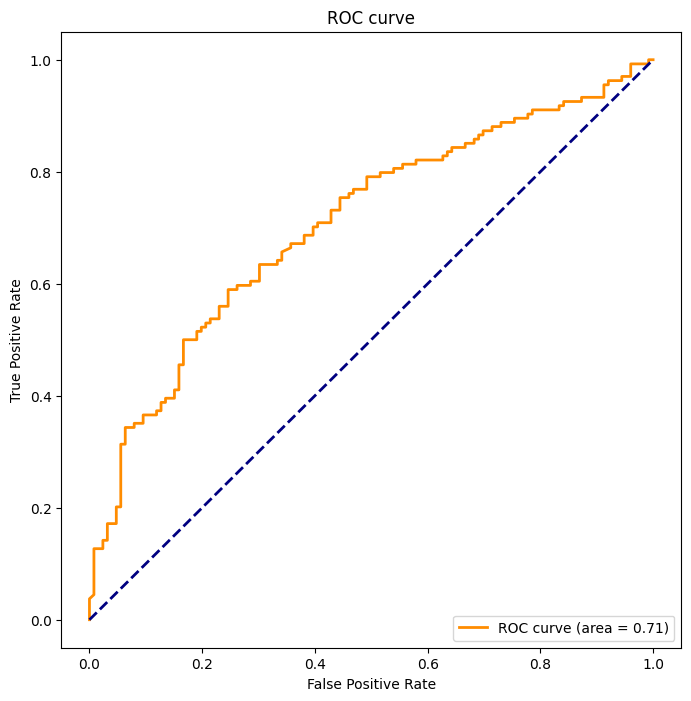

In [47]:
fpr, tpr, _ = roc_curve(y_truth, y_pred)
roc_auc = auc(fpr, tpr)

# plot roc_Auc
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")


In [33]:
fpr

array([0.        , 0.75396825, 1.        ])

**A**: Based on the experimental results, it seems that including the supertype feature leads to a slight improvement in performance accuracy. It's intriguing to observe that the optimal value for C in this scenario remains consistent with the previous case. However, it's essential to acknowledge that this value might vary from one run to another without a fixed random seed.

**(d)** Generate a ROC curve that shows the performances of the different approaches. For ```R``` you can use the ```ROCR``` package. Calculate AUCs to compare the different approaches and comment on your findings.

In [48]:
def ROC(results, title='ROC Curve'):
    fpr = {}
    tpr = {}
    roc_auc = {}
    for key in results.keys():
        y_pred, y_truth = results[key]
        fpr[key], tpr[key], _ = roc_curve(y_truth, y_pred)
        roc_auc[key] = auc(fpr[key], tpr[key])

    # Plot ROC curve
    plt.figure(figsize=(10, 10))
    lw = 2
    for key in results.keys():
        plt.plot(fpr[key], tpr[key], lw=lw, label='ROC curve of {} (area = {:.4f})'.format(key, roc_auc[key]))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.005, 1.0])
    plt.ylim([0.0, 1.005])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()


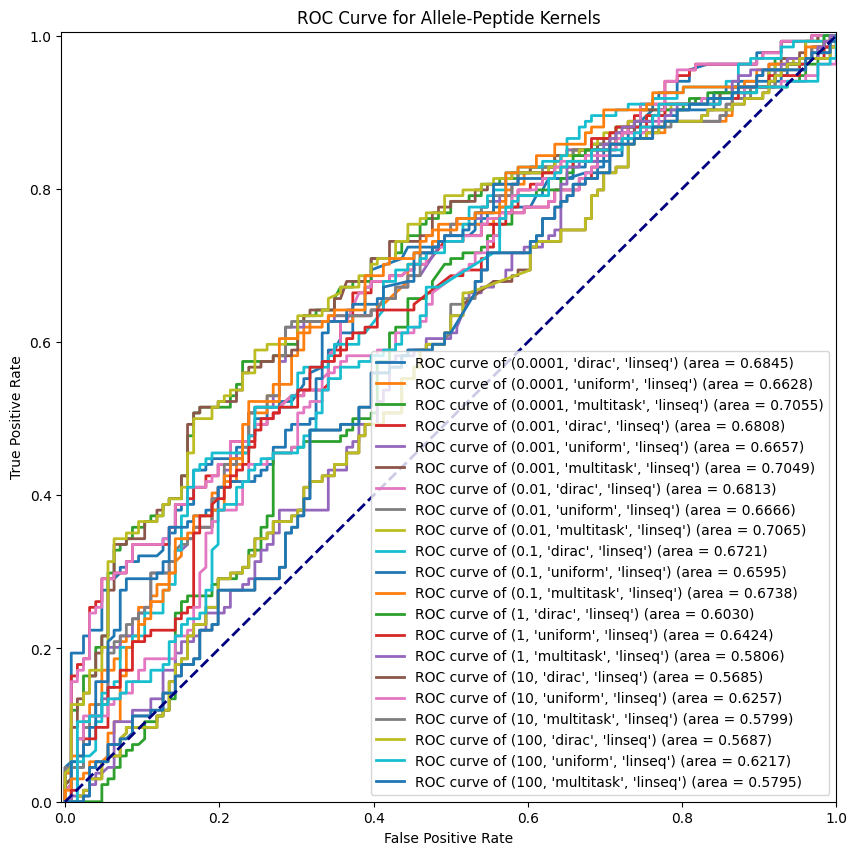

In [49]:
ROC(test_output, title="ROC Curve for Allele-Peptide Kernels")

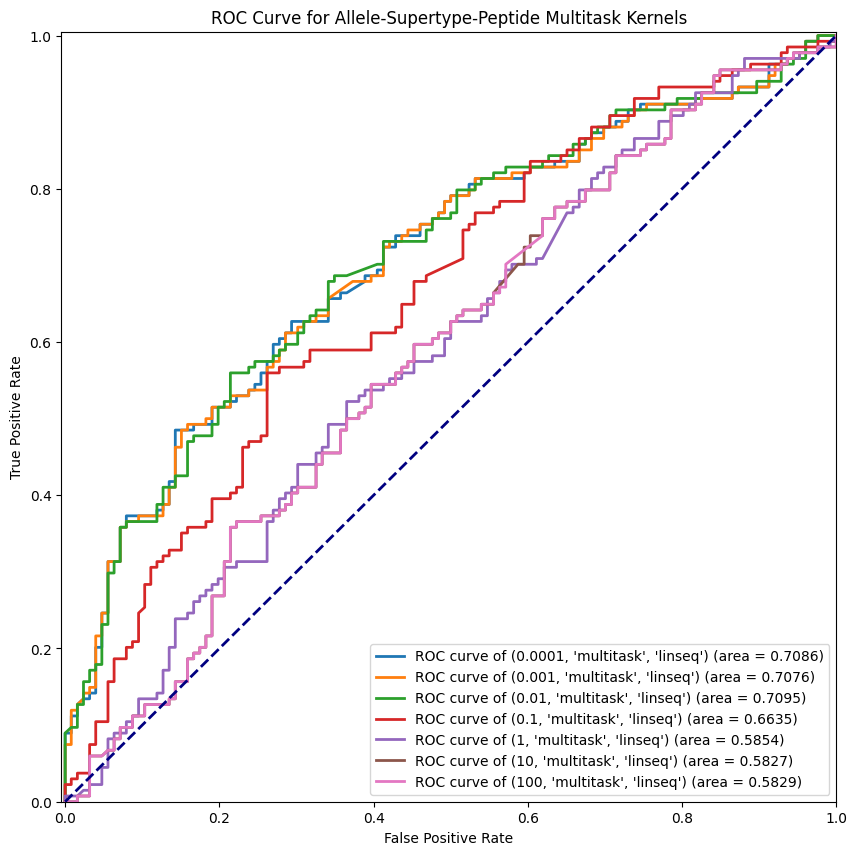

In [58]:
ROC(test_output_sup, title="ROC Curve for Allele-Supertype-Peptide Multitask Kernels")

**Q**: In the visualization, it's evident that the combination of the ```Multitask``` Kernel with the ```Linseq``` outperforms the others when $C$ is set to 1. It's worth noting, though, that this superiority is not consistently decisive; the outcome might vary randomly from run to run. For lower values of $C$, the models exhibit behavior akin to a random classifier. On the whole, it seems that the sweet spot for optimal $C$ is around 0.1, where all three kernels show satisfactory performance.

**(e)** Compare AUCs to accuracy, and discuss possible discrepancies.

**Q**: The AUC (Area Under the Curve) is typically associated with receiver operating characteristic (ROC) curves, while accuracy is a more straightforward measure of overall correctness. If the classes are imbalanced, accuracy might appear high even if the model struggles to correctly classify the minority class. AUC can provide a more nuanced view by considering the true positive rate across various thresholds. The choice between AUC and accuracy depends on the specific goals of the classification task. For instance, in medical diagnosis, where false positives and false negatives may have different consequences, AUC might be more informative. On the other hand, accuracy treats false positives and false negatives equally. If the consequences of both types of errors are comparable, accuracy is a suitable metric. But, as can be seen from the results, outputs of both of the metrics tend to be highly correlated with each other.